In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import networkx as nx
import tensorflow as tf
import numpy as np
from utils.utils import predict
import matplotlib.pyplot as plt

In [2]:
model_m_to_s = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_m_to_s", compile=True)
model_s_to_m = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_s_to_m", compile=True)

In [3]:
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)

In [4]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('uint8')
rdkit.columns = rdkit.columns.astype(str)
#molecule_features_dummy = molecule_features_dummy.merge(rdkit,
#                                                        left_index=True,
#                                                        right_index=True)

In [5]:
g_train = nx.read_graphml("./graph/train_graph.gml")
g = nx.read_graphml("./graph/test_graph.gml")
g  = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [6]:
df_agg_train = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [ ]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [ ]:
species_unique_to_test_set = df_agg[~df_agg.organism_name.isin(df_agg_train.organism_name)]
molecules_unique_to_test_set = df_agg[~df_agg.structure_smiles_2D.isin(df_agg_train.structure_smiles_2D)]

In [ ]:
data = pd.DataFrame(df_agg[['structure_smiles_2D', 'organism_name']].to_numpy(),
                    columns=['molecule', 'species'])

In [ ]:
#out = predict(g_train, model_m_to_s, model_s_to_m, data, molecule_features_dummy, species_features_dummy)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(out.prob)

In [ ]:
sum(out.prob>0.5)/len(out)

In [ ]:
out[out.model!='both_known']

In [ ]:
data_2 = pd.DataFrame(
    molecules_unique_to_test_set[['organism_name', 'structure_smiles_2D']].values,
    columns=['species', 'molecule'])

In [ ]:
data_2

In [ ]:
out_2 = predict(g_train, model_m_to_s, model_s_to_m,
                data_2,
                molecule_features_dummy,
                species_features_dummy
               )

In [ ]:
plt.hist(out_2.prob)

In [7]:
g_test = nx.read_graphml("./graph/test_graph.gml")
g_lotus = nx.compose(g_train, g_test)

In [8]:
sku = pd.concat([df_agg, df_agg_train])

In [9]:
sp = 'Trigonostemon reidioides'
data_3 = pd.DataFrame(
    {'molecule': list(set(molecule_features_dummy.index)-set(sku[sku.organism_name==sp].structure_smiles_2D)),
     'species': sp})

In [ ]:
data_3

In [10]:
mols_classyfire = sku[['structure_taxonomy_classyfire_01kingdom',
       'structure_taxonomy_classyfire_02superclass',
       'structure_taxonomy_classyfire_03class',
       'structure_taxonomy_classyfire_04directparent']].copy()

In [11]:
mols_classyfire.index = sku.structure_smiles_2D
mols_classyfire = mols_classyfire[~mols_classyfire.index.duplicated(keep='first')]

In [12]:
species_taxo = sku[['kingdom','phylum','class','order','family','genus', 'organism_name']].copy()

In [13]:
species_taxo.index = sku.organism_name
species_taxo = species_taxo[~species_taxo.index.duplicated(keep='first')]

In [ ]:
out_3 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_3,
                mols_classyfire,
                rdkit,
                species_taxo
               )

In [ ]:
plt.hist(out_3.prob, bins=200)

In [ ]:
out_3[out_3.prob>0.95]

# Test 4: let's see if cholesterol is present "everywhere"


In [19]:
mol = 'HVYWMOMLDIMFJA-DPAQBDIFSA-N'
data_4 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))})

In [15]:
data_4 = pd.DataFrame(
    data={'molecule': mol,
     'species': ['Monstera adansonii', 'Monstera egregia']})

In [ ]:
data_4

In [20]:
out_4 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_4,
                mols_classyfire,
                rdkit,
                species_taxo
               )

Converting Inchikeys to SMILES...
Getting missing features...
None
Converting species taxonomy as numeric...
Converting molecules as numeric...
Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184195, Edges: 869484

 Node types:
  molecule: [147748]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating mol to species flow...
Predicting mol to species...
36/36 [==============================] - 7s 179ms/step


In [21]:
out_4

,molecule,species,model,prob
0,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Sirococcus conorum,m_to_s,0.774194
1,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Xestospongia testudinaria,m_to_s,0.886120
2,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Anadara broughtonii,m_to_s,0.358161
3,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Medicago rigidula,m_to_s,0.113697
4,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Trichoderma saturnisporum,m_to_s,0.855042
...,...,...,...,...
36442,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Cetraria tenuifolia,m_to_s,0.629371
36443,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Penstemon procerus,m_to_s,0.408119
36444,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Phedimus aizoon,m_to_s,0.933041
36445,CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C,Hedeoma pulegioides,m_to_s,0.694848


(array([1037.,  685.,  521.,  422.,  384.,  333.,  320.,  290.,  256.,
         261.,  241.,  277.,  242.,  220.,  229.,  193.,  234.,  197.,
         217.,  200.,  212.,  201.,  192.,  182.,  158.,  192.,  198.,
         156.,  174.,  159.,  156.,  164.,  149.,  185.,  160.,  154.,
         164.,  155.,  138.,  165.,  131.,  168.,  132.,  164.,  146.,
         143.,  138.,  151.,  159.,  131.,  148.,  156.,  140.,  128.,
         131.,  139.,  138.,  132.,  134.,  142.,  129.,  136.,  117.,
         149.,  131.,  137.,  118.,  133.,  138.,  121.,  139.,  129.,
         137.,  110.,  105.,  147.,  124.,  115.,  118.,  140.,  110.,
         119.,  126.,  138.,  137.,  133.,  140.,  126.,  140.,  140.,
         125.,  142.,  124.,  121.,  122.,  116.,  104.,  128.,  135.,
         122.,  132.,  139.,  105.,  119.,  130.,  140.,  103.,  134.,
         139.,  133.,  130.,  126.,  129.,  103.,  116.,  127.,  135.,
         127.,  131.,  123.,  148.,  117.,  130.,  154.,  116.,  148.,
      

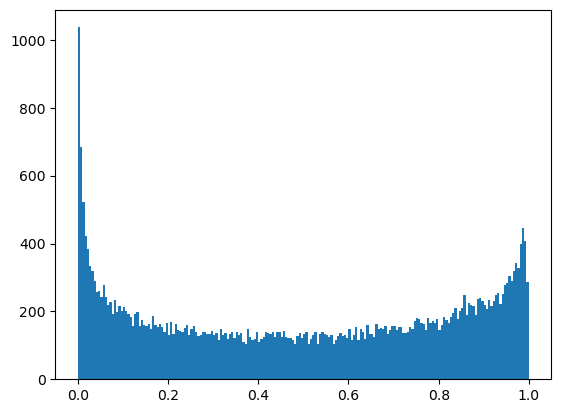

In [22]:
plt.hist(out_4.prob, bins=200)

In [ ]:
len(out_4[out_4.prob>0.5])/len(out_4)

In [ ]:
out_4[out_4.prob>0.95]

# Test 5: test with a more rare molecule 

In [23]:
mol = 'ULGZDMOVFRHVEP-UHFFFAOYSA-N'
data_5 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))}
)

In [24]:
out_5 = predict(g_lotus,
                model_m_to_s,
                model_s_to_m,
                data_5,
                mols_classyfire,
                rdkit,
                species_taxo
               )

Converting Inchikeys to SMILES...
Getting missing features...
None
Converting species taxonomy as numeric...
Converting molecules as numeric...
Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184195, Edges: 869484

 Node types:
  molecule: [147748]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating mol to species flow...
Predicting mol to species...
36/36 [==============================] - 12s 320ms/step


(array([9663., 2096., 1241.,  953.,  809.,  712.,  564.,  513.,  437.,
         418.,  437.,  358.,  346.,  340.,  298.,  277.,  270.,  269.,
         268.,  253.,  226.,  243.,  232.,  201.,  241.,  186.,  216.,
         185.,  204.,  155.,  199.,  216.,  153.,  175.,  159.,  165.,
         142.,  162.,  135.,  141.,  132.,  152.,  147.,  135.,  116.,
         153.,  111.,  136.,  131.,  130.,  131.,  134.,  129.,  117.,
         106.,  114.,  114.,  119.,  116.,  115.,  102.,   89.,   90.,
         111.,   89.,  110.,  101.,   85.,   90.,   93.,   98.,   93.,
          67.,   84.,   95.,  101.,   89.,   87.,   92.,   90.,   84.,
          86.,   84.,   80.,   73.,   94.,   84.,   81.,   61.,   59.,
          74.,   72.,   64.,   90.,   83.,   85.,   67.,   80.,   74.,
          59.,   73.,   70.,   75.,   71.,   76.,   58.,   74.,   62.,
          70.,   58.,   55.,   54.,   67.,   53.,   52.,   52.,   69.,
          60.,   65.,   60.,   56.,   48.,   50.,   57.,   62.,   57.,
      

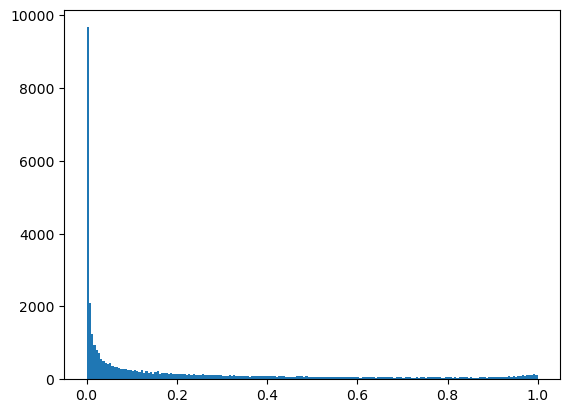

In [25]:
plt.hist(out_5.prob, bins=200)

In [26]:
out_5[out_5.prob>0.95]

,molecule,species,model,prob
4,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Trichoderma saturnisporum,m_to_s,0.997295
10,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Picrolemma huberi,m_to_s,0.962884
39,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Amycolatopsis mediterranei,m_to_s,0.998431
40,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Streptomyces viridochromogenes,m_to_s,0.975919
50,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Anthracophyllum,m_to_s,0.968318
...,...,...,...,...
36354,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Calicogorgia,m_to_s,0.955803
36367,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Bipolaris cynodontis,m_to_s,0.993981
36374,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Penicillium aurantiovirens,m_to_s,0.964487
36401,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,Omphalotus olivascens,m_to_s,0.987199
